In [1]:
import jax 
import jax.numpy as jnp
import numpy as np

import haiku as hk

import torch

import matplotlib.pyplot as plt

from scoresbibm.tasks import get_task
from scoresbibm.methods.score_transformer import run_train_transformer_model
from scoresbibm.methods.neural_nets import scalar_transformer_model
from scoresbibm.methods.sde import init_sde_related
from scoresbibm.utils.plot import use_style

# generate dataset

In [2]:
# we have two parameters, theta1 and theta2
# we have two outputs, y1 and y2, corresponding to the measurement with two different detectors

npoints = 200

nobs = 10_000
wavefun = lambda theta1, theta2, x: jnp.sin(theta1*x)*jnp.cos(theta2*x)


rng = jax.random.PRNGKey(42)
rng, key = jax.random.split(rng)
x1 = np.linspace(0, 2*np.pi, npoints).reshape(1,-1)
x2 = np.linspace(0, 2*np.pi, npoints).reshape(1,-1)
thetas = jax.random.normal(key, (nobs,2))+0.2
noise1 = jax.random.normal(key, (nobs,npoints))*0.2
noise2 = jax.random.normal(key, (nobs,npoints))*0.5

xs1 = wavefun(thetas[:,0:1], thetas[:,1:2],x1) + noise1
xs2 = wavefun(thetas[:,0:1], thetas[:,1:2],x2) + noise2

xs1 = xs1.reshape(nobs,1,npoints)
xs2 = xs2.reshape(nobs,1,npoints)

xs = jnp.concatenate([xs1,xs2],axis=1)


In [3]:
xs.shape, thetas.shape

((10000, 2, 200), (10000, 2))

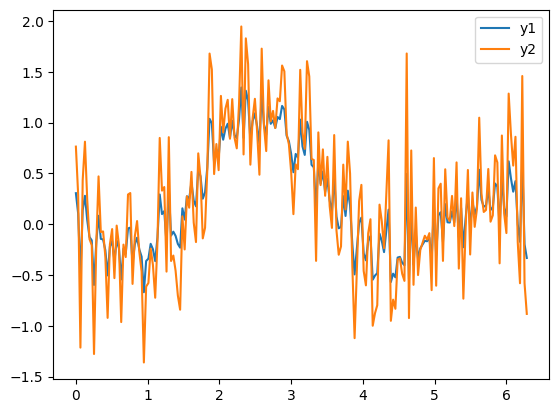

In [7]:
i=5
plt.plot(x1[0,:], xs1[i,0,:], label='y1')
plt.plot(x2[0,:], xs2[i,0,:], label='y2')
plt.legend()
plt.show()

# data preprocessing

In [8]:
thetas_mean = jnp.mean(thetas, axis=0, keepdims=True)
thetas_std = jnp.std(thetas, axis=0, keepdims=True)

thetas = (thetas - thetas_mean) / thetas_std

In [9]:
def z_score_thetas(thetas):
    thetas = (thetas - thetas_mean) / thetas_std
    return thetas

def un_z_score_thetas(thetas):
    thetas = thetas * thetas_std + thetas_mean
    return thetas

In [10]:
xs_mean = jnp.mean(xs, axis=0, keepdims=True)
xs_mean = jnp.mean(xs_mean, axis=-1, keepdims=True)
xs_std = jnp.std(xs, axis=0, keepdims=True)
xs_std = jnp.std(xs_std, axis=-1, keepdims=True)

xs = (xs - xs_mean) / xs_std

In [11]:
def z_score_xs(xs):
    xs = (xs - xs_mean) / xs_std
    return xs

def un_z_score_xs(xs):
    xs = xs * xs_std + xs_mean
    return xs

In [12]:
def ravel(data, axis=-1):
    flat_data, tree = jax.tree_util.tree_flatten(data)
    split_dims = np.cumsum(np.array([flat.shape[axis] for flat in flat_data]))[:-1]
    flat_data = jnp.concatenate(flat_data, axis=axis)
    def unravel(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        flat_data = jax.tree_util.tree_unflatten(tree, flat_data)
        return flat_data
    def unflatten(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        return flat_data 
    return flat_data, unravel, unflatten

In [13]:
data = {"theta0": thetas[:, 0][:, None], "theta1": thetas[:, 1][:, None], "x0": xs[:, 0], "x1": xs[:, 1]}
data_flat, unravel, unflatten = ravel(data)
theta_dim = 2
x_dim = data_flat.shape[-1] - theta_dim
node_id = jnp.arange(0, 4)
condition_mask = jnp.array([False]*theta_dim + [True]*x_dim)

In [14]:
sde, T_min, T_max, weight_fn, output_scale_fn =  init_sde_related(data_flat, "vesde", sigma_min=1e-5, sigma_max=15.)

In [15]:
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.transformers import Transformer


token_dim = 100
id_dim = 40
cond_dim = 10

embedding_net1 = lambda x: jnp.repeat(x, token_dim, axis=-1)

embedding_net2 = lambda x:hk.Sequential([
        hk.Conv1D(output_channels=16, kernel_shape=9, stride=2, padding='SAME', name='conv1'), # 4000
        jax.nn.gelu,
        hk.Conv1D(output_channels=32, kernel_shape=6, stride=2, padding='SAME', name='conv2'), # 2000
        jax.nn.gelu,
        hk.Conv1D(output_channels=64, kernel_shape=3, stride=2, padding='SAME', name='conv3'), # 1000
        jax.nn.gelu,
        hk.Conv1D(output_channels=128, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 500
        jax.nn.gelu,
        hk.Conv1D(output_channels=256, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 250
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 125
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 64
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 32
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 16
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 8
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 4
        jax.nn.gelu,
        hk.Flatten(),
        hk.Linear(token_dim, name='linear'),
    ])(x)[..., None,:]

embedding_nets = [embedding_net1,embedding_net1, embedding_net2, embedding_net2]
output_fn = [lambda x: hk.Linear(1)(x), lambda x: hk.Linear(1)(x), lambda x: hk.Linear(npoints)(x), lambda x: hk.Linear(npoints)(x)]


def model(t, data, data_id, condition_mask, edge_mask=None):
    
    data = unflatten(data)

    assert len(data) == len(embedding_nets), "Number of data elements and embedding nets must match"
    
    data_embedded = jax.tree_map(lambda x, net: net(x[..., :,None]), data, embedding_nets)

    data_embedded = jnp.concatenate(data_embedded, axis=-2)
    
    _, current_nodes, _ = data_embedded.shape
    
    time_embeder = GaussianFourierEmbedding(128)
    id_embedder= hk.Embed(4, id_dim)
    
    id_embedding = id_embedder(data_id)
    id_embedding = jnp.broadcast_to(
        id_embedding, data_embedded.shape[:-1] + (id_dim,)
    )
    tokens = jnp.concatenate([data_embedded, id_embedding], axis=-1)
    time = time_embeder(t[..., None])
    
    condition_token = hk.get_parameter(
        "condition_token",
        shape=[1, 1, cond_dim],
        init=hk.initializers.RandomNormal(
            0.01, 0.
        ),
    )
    condition_mask = unflatten(condition_mask)
    condition_mask = jax.tree_map(lambda x: jnp.any(x, axis=-1, keepdims=True), condition_mask)
    condition_mask = jnp.concatenate(condition_mask, axis=-1)
    condition_mask = condition_mask.reshape(-1, current_nodes, 1)
    condition_token = condition_mask * condition_token
  
    condition_token = jnp.broadcast_to(
        condition_token, tokens.shape[:-1] + (cond_dim,)
    )
    tokens = jnp.concatenate([tokens, condition_token], -1)

    
    model = Transformer(
        num_heads=4,
        num_layers=8,
        attn_size=20,
        widening_factor=3,
    )
    
    h = model(tokens, context=time, mask=edge_mask)
    out = jnp.split(h, current_nodes, axis=-2)
    out = jax.tree_map(lambda x, fn: fn(x), out, output_fn)
    out = jnp.concatenate(out, axis=-1)
    out = jnp.squeeze(out, axis=-2)
    out = output_scale_fn(t, out)

    return out
    
    
init_fn, model_fn = hk.without_apply_rng(hk.transform(model))


In [16]:
params = init_fn(jax.random.PRNGKey(42), jnp.ones((1,)), data_flat[:10], node_id, condition_mask)

In [17]:
out = model_fn(params, jnp.ones((1,))*0.01, data_flat[:10], node_id, condition_mask)

In [18]:
import optax
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)

In [19]:
from probjax.nn.loss_fn import denoising_score_matching_loss
from functools import partial




@jax.jit
def loss_fn(params, key, data, node_id):
    key_times, key_loss, key_condition = jax.random.split(key,3)
    times = jax.random.uniform(key_times, (data.shape[0],), minval=T_min, maxval =T_max)
    condition_mask1 = jnp.array([False]*theta_dim + [True]*x_dim)
    condition_mask2 = jnp.array([False]*theta_dim + [True]*(x_dim//2) + [False]*(x_dim//2))
    condition_mask3 = jnp.array([False]*theta_dim + [False]*(x_dim//2) + [True]*(x_dim//2))

    edge_mask1 = jnp.ones((4,4), dtype=bool)
    # Partial posterior
    edge_mask2 = edge_mask1.at[:, 2].set(False)
    edge_mask2 = edge_mask2.at[2, :].set(False)
    # Partial posterior 2
    edge_mask3 = edge_mask1.at[:, 3].set(False)
    edge_mask3 = edge_mask3.at[3, :].set(False)
    
    edge_masks = jax.random.choice(key_condition, jnp.stack([edge_mask1, edge_mask2, edge_mask3]), (data.shape[0],))
    condition_mask = jax.random.choice(key_condition, jnp.stack([condition_mask1, condition_mask2, condition_mask3]), (data.shape[0],))
    l_mask = jnp.broadcast_to(condition_mask1, (data.shape[0],) + condition_mask1.shape)
    
    loss = denoising_score_matching_loss(params, key_loss, times, data, l_mask, node_id, model_fn = model_fn, mean_fn = sde.marginal_mean, std_fn=sde.marginal_stddev, weight_fn=weight_fn, edge_mask=edge_masks, condition_mask=condition_mask, axis=-1)
    return loss



@partial(jax.pmap, axis_name="num_devices")
def update(params, opt_state, key, data, node_id):
    loss, grads = jax.value_and_grad(loss_fn)(params, key, data, node_id)

    loss = jax.lax.pmean(loss, axis_name="num_devices")
    grads = jax.lax.pmean(grads, axis_name="num_devices")
    
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state
    

In [20]:
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)

In [21]:
key = jax.random.PRNGKey(0)

In [91]:

node_id_repeated = node_id[None, ...]
node_id_repeated = jnp.repeat(node_id_repeated, n_devices, axis=0)
for _ in range(40):
    l = 0
    for _ in range(2000):
        key, subkey = jax.random.split(key)
        data_batch = jax.random.choice(subkey, data_flat, (n_devices, 32))
        loss, replicated_params, replicated_opt_state = update(replicated_params, replicated_opt_state, jax.random.split(subkey, (n_devices,)), data_batch, node_id_repeated)
        l += loss[0] / 2000
    print(l)



47.502163
44.375477
43.086643
41.226715
40.116547
39.99067
39.784912
38.900665
38.639366
38.298985
38.304626
37.7857
37.420208
37.158463
36.911316
36.969673
36.7259
36.583954
36.427593
36.191494
36.33465
36.10807
36.282513
36.00051
35.839714
36.087635
35.43106
35.895172
35.702484
35.548725
35.26001
35.327602
34.971542
35.451912
35.484608
35.24597
35.173893
35.204224
34.779285
35.08374


In [22]:
params = jax.tree_map(lambda x: x[0], replicated_params)

In [23]:
# jnp.save("only_post_params.pt", params)
params = jnp.load("only_post_params.pt.npy", allow_pickle=True).item()

In [24]:
end_mean = sde.marginal_mean(jnp.array(1.0))[None, ...]
end_mean = jax.device_put(end_mean, jax.devices()[0])

In [25]:
end_std = sde.marginal_stddev(jnp.array(1.0))[None, ...]
end_std = jax.device_put(end_std, jax.devices()[0])

# now we do the backward diffusion to get the posterior

In [26]:
from functools import partial
from probjax.utils.sdeint import sdeint


# Reverse SDE drift
def drift_backward(t, x, node_ids=None, condition_mask=None, edge_mask=None, score_fn = model_fn):
    score = score_fn(params, t.reshape(-1, 1), x[None,...], node_ids,condition_mask, edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    f = f * (1-condition_mask)
    
    return f.reshape(x.shape)

# Reverse SDE diffusion
def diffusion_backward(t,x, **kwargs):
    #t = T - t
    b =  sde.diffusion(t,x) 
    b = b * (1-condition_mask)
    return b.reshape(x.shape)

In [27]:
def sample_fn(key, shape, node_ids,condition_mask, condition_value, time_steps=1000, edge_mask=None, score_fn=model_fn):

    key1, key2 = jax.random.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (condition_value.shape[0],)) * end_std + end_mean

    
    x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Solve backward sde
    keys = jax.random.split(key2, shape)
    # ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal", only_final=True), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn), lambda t, x: diffusion_backward(t, x), x_T, jnp.linspace(1.,T_min, time_steps))
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn), lambda t, x: diffusion_backward(t, x), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys

In [28]:
nobs = 1000

rng = jax.random.PRNGKey(420)
rng, key = jax.random.split(rng)
x1 = np.linspace(0, 2*np.pi, npoints).reshape(1,-1)
x2 = np.linspace(0, 2*np.pi, npoints).reshape(1,-1)
thetas_test = jax.random.normal(key, (nobs,2))+0.2
noise1 = jax.random.normal(key, (nobs,npoints))*0.2
noise2 = jax.random.normal(key, (nobs,npoints))*0.5

xs1 = wavefun(thetas_test[:,0:1], thetas_test[:,1:2],x1) + noise1
xs2 = wavefun(thetas_test[:,0:1], thetas_test[:,1:2],x2) + noise2

xs1 = xs1.reshape(nobs,1,npoints)
xs2 = xs2.reshape(nobs,1,npoints)

xs_test = jnp.concatenate([xs1,xs2],axis=1)

In [29]:
thetas_test = (thetas_test - thetas_mean) / thetas_std
xs_test = (xs_test - xs_mean) / xs_std

In [30]:
data_test = {"theta0": thetas_test[:, 0][:, None], "theta1": thetas_test[:, 1][:, None], "x0": xs_test[:, 0], "x1": xs_test[:, 1]}
data_test_flat, _, _ = ravel(data_test)

In [31]:
edge_mask = jnp.ones((4,4), dtype=bool)
edge_mask1 = edge_mask.at[:, 2].set(False)
edge_mask1 = edge_mask1.at[2, :].set(False)

edge_mask2 = edge_mask.at[:, 3].set(False)
edge_mask2 = edge_mask2.at[3, :].set(False)

In [32]:
index = 42
x_o = jax.device_put(data_test_flat[index], jax.devices()[0])
x_o[:2]

Array([-0.919, -0.509], dtype=float32)

In [33]:
sample = sample_fn(jax.random.PRNGKey(0), (2000,), node_id, condition_mask, x_o)

In [34]:
x_o_dict = unravel(x_o)

In [36]:
sample_partial1 = sample_fn(jax.random.PRNGKey(1), (2000,), node_id, condition_mask, x_o, edge_mask=edge_mask1)
sample_partial2 = sample_fn(jax.random.PRNGKey(2), (2000,), node_id, condition_mask, x_o, edge_mask=edge_mask2)

In [ ]:
thetas = un_z_score_thetas(sample[:, :2])
thetas_partial1 = un_z_score_thetas(sample_partial1[:, :2])
thetas_partial2 = un_z_score_thetas(sample_partial2[:, :2])
theta_true = un_z_score_thetas(x_o[:2])